# Problem ID

Identify which factors or features predict future user adoption.

"Adopted user" is defined as a user who has logged into the product on 3 separate days in at least one seven­ day period.

To understand what the columns / features mean look at the PDF in the same directory.

# Initial Setup

In [1]:
# import lib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# convert csv to df
engagement_df = pd.read_csv('takehome_user_engagement.csv')
users_df = pd.read_csv('takehome_users.csv',encoding='latin-1')

In [3]:
# preview
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
# preview
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


# Data Wrangling

In [5]:
# check for missing values

# Check missing values in both datasets
missing_values_engagement = engagement_df.isnull().sum()
missing_values_users = users_df.isnull().sum()

# Display missing values
missing_values_engagement, missing_values_users

# I see missing values in users df but they don't seem to affect the main objective so will keep them.

(time_stamp    0
 user_id       0
 visited       0
 dtype: int64,
 object_id                        0
 creation_time                    0
 name                             0
 email                            0
 creation_source                  0
 last_session_creation_time    3177
 opted_in_to_mailing_list         0
 enabled_for_marketing_drip       0
 org_id                           0
 invited_by_user_id            5583
 dtype: int64)

In [6]:
# Convert to datetime 

# Convert creation_time to datetime
users_df["creation_time"] = pd.to_datetime(users_df["creation_time"])

# Convert last_session_creation_time (UNIX timestamp) to datetime, handling NaN values
users_df["last_session_creation_time"] = pd.to_datetime(users_df["last_session_creation_time"], unit='s', errors='coerce')

# Convert engagement time_stamp to datetime
engagement_df["time_stamp"] = pd.to_datetime(engagement_df["time_stamp"])


In [7]:
users_df[["creation_time", "last_session_creation_time"]].head()

,creation_time,last_session_creation_time
0,2014-04-22 03:53:30,2014-04-22 03:53:30
1,2013-11-15 03:45:04,2014-03-31 03:45:04
2,2013-03-19 23:14:52,2013-03-19 23:14:52
3,2013-05-21 08:09:28,2013-05-22 08:09:28
4,2013-01-17 10:14:20,2013-01-22 10:14:20


In [8]:
engagement_df["time_stamp"].head()

0   2014-04-22 03:53:30
1   2013-11-15 03:45:04
2   2013-11-29 03:45:04
3   2013-12-09 03:45:04
4   2013-12-25 03:45:04
Name: time_stamp, dtype: datetime64[ns]

# EDA

In [9]:
# Group by user and find adopted users
def is_adopted_user(user_logins_s):
    """Check if a user has logged in on 3 separate days within any 7-day window."""
    user_logins_unique_s = sorted(set(user_logins_s))  # Get unique login days
    for i in range(len(user_logins_unique_s) - 2): # Stop 2 indices before the end to check 3-day condition
        if (user_logins_unique_s[i+2] - user_logins_unique_s[i]).days <= 7: # Check if there exists a sequence where three logins fall within 7 days
            return 1  # User is adopted
    return 0  # Not adopted

# Identify adopted users
adopted_users = (
    engagement_df
    .groupby("user_id")["time_stamp"] # create separate series of time stamps only for that uses
    .apply(is_adopted_user) # then apply function to each element of the series, will have a df saying if a user is considered an adopted user
    .reset_index()
    .rename(columns={"time_stamp": "adopted_user"}) 
)

adopted_users.head() # 1 means adopted, 0 means not

,user_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [10]:
# Merge / add adopted user status onto user data
users_df = users_df.rename(columns={"object_id": "user_id"})  # Rename for merging
merged_df = users_df.merge(adopted_users, on="user_id", how="left")

In [11]:
# Fill NaN values for users who never logged in (assume not adopted)
merged_df["adopted_user"] = merged_df["adopted_user"].fillna(0).astype(int)

In [12]:
# preview
merged_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [13]:
# Convert creation time to datetime and extract useful time-based features
merged_df["creation_time"] = pd.to_datetime(merged_df["creation_time"])
merged_df["account_age_days"] = (merged_df["creation_time"].max() - merged_df["creation_time"]).dt.days

# Convert last session creation time from Unix timestamp to datetime
merged_df["last_session_creation_time"] = pd.to_datetime(merged_df["last_session_creation_time"], unit="s")

# Compute time since last login (for users with recorded sessions)
merged_df["days_since_last_login"] = (merged_df["creation_time"].max() - merged_df["last_session_creation_time"]).dt.days

# Fill missing values with a high number (indicating never logged in)
merged_df["days_since_last_login"] = merged_df["days_since_last_login"].fillna(9999)

merged_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,account_age_days,days_since_last_login
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,38,38.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,196,60.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,437,437.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,374,373.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,498,493.0


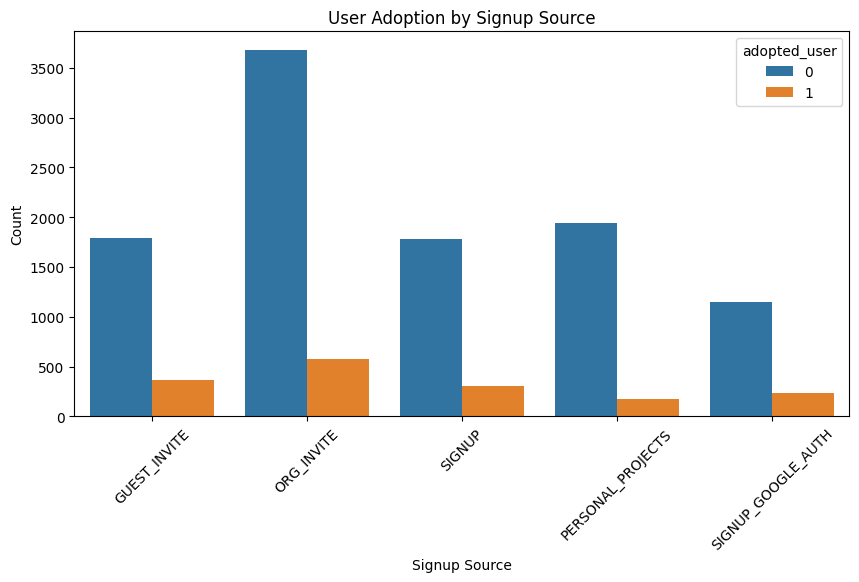

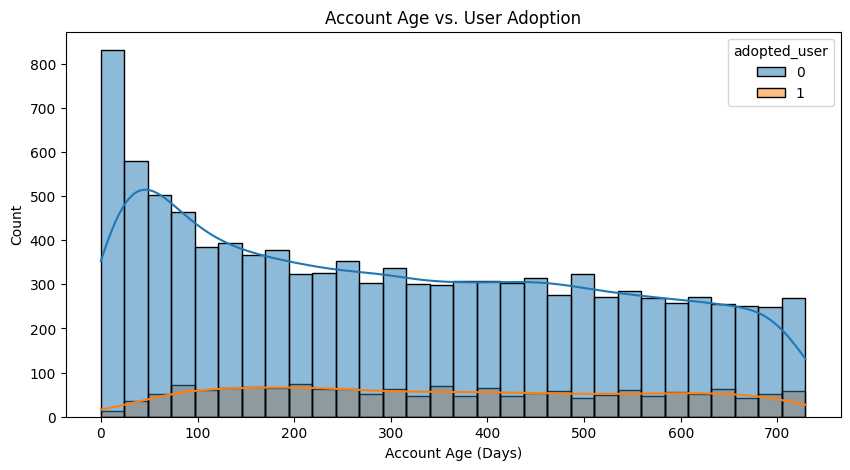

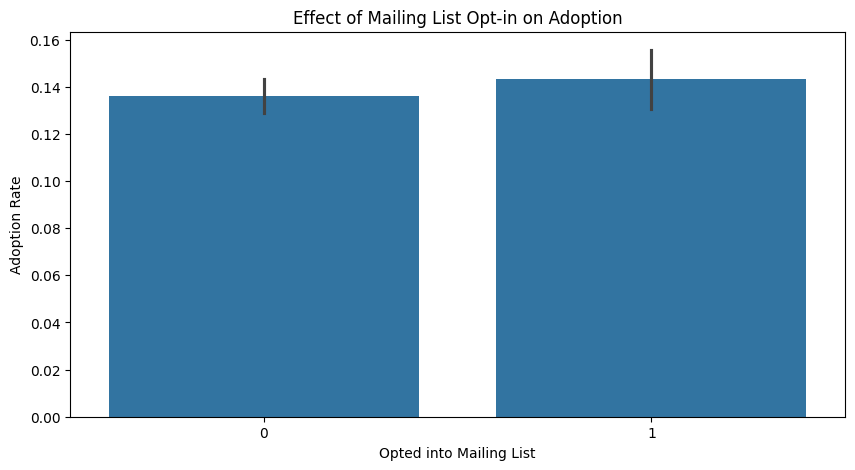

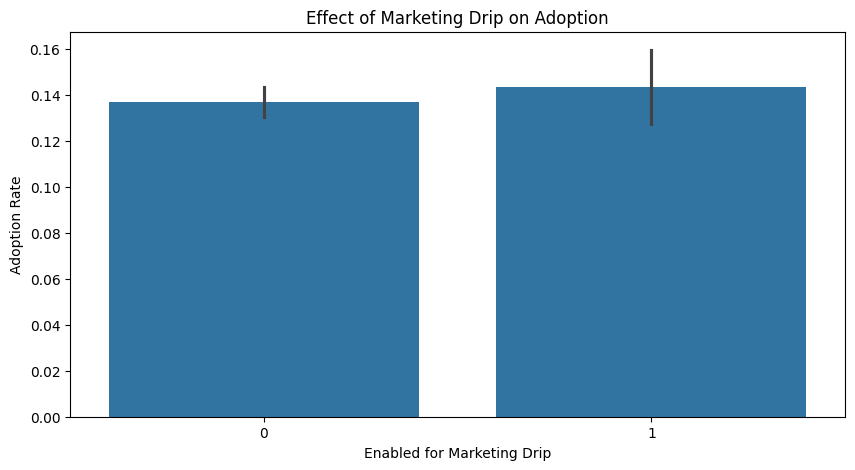

In [14]:
# Plot distribution of adopted vs. non-adopted users by signup source
plt.figure(figsize=(10, 5))
sns.countplot(data=merged_df, x="creation_source", hue="adopted_user")
plt.xticks(rotation=45)
plt.title("User Adoption by Signup Source")
plt.xlabel("Signup Source")
plt.ylabel("Count")
plt.show()

# Plot distribution of account age vs adoption
plt.figure(figsize=(10, 5))
sns.histplot(data=merged_df, x="account_age_days", hue="adopted_user", bins=30, kde=True)
plt.title("Account Age vs. User Adoption")
plt.xlabel("Account Age (Days)")
plt.ylabel("Count")
plt.show()

# Plot impact of marketing preferences on adoption
plt.figure(figsize=(10, 5))
sns.barplot(data=merged_df, x="opted_in_to_mailing_list", y="adopted_user")
plt.title("Effect of Mailing List Opt-in on Adoption")
plt.xlabel("Opted into Mailing List")
plt.ylabel("Adoption Rate")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=merged_df, x="enabled_for_marketing_drip", y="adopted_user")
plt.title("Effect of Marketing Drip on Adoption")
plt.xlabel("Enabled for Marketing Drip")
plt.ylabel("Adoption Rate")
plt.show()

# Discovery

- Just by looking at the graphs is seems to appear that ORG_INVITE have the highest adoption rate. Thus users invited into the organization seem to engage and stay with the product more. Maybe there is also a factor of their social group on the platform as this is their digital meet up place, and too much of a hassle to move the friend group somewhere else. 
- In the Account age & Adoption graph, it seems to show that their are more younger accounts but they don't seem to convert well. While older accounts have steady stream of people trying and adopting. This may imply a bit that our platform may be less popular for young people, maybe they are 'moving on to the next big social platform'.
- Both Mailing and Marketing doesn't seem to have much different in conversion as both non adopt and adopt have equal levels with margin of errors that encompass the other category and thus no significance.

Overall the strongest factor to make people adopt seems to be Org Invites which we should probably lean more on.